## Observational social learning task with a basic working-memory-based network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
from WM import *

### Dynamics

    sid  trial  network  stage  who  color  degree       RD  action
10    1      2       15      0    3      1       2  0.00000       1
11    1      2       15      1    7      0       5  0.55556       1
12    1      2       15      1    4      1       2  0.22222       1
13    1      2       15      2    4      1       2  0.22222       1
14    1      2       15      2    7      0       5  0.55556       1
15    1      2       15      3    7      0       5  0.55556       0
16    1      2       15      3    4      1       2  0.22222       0


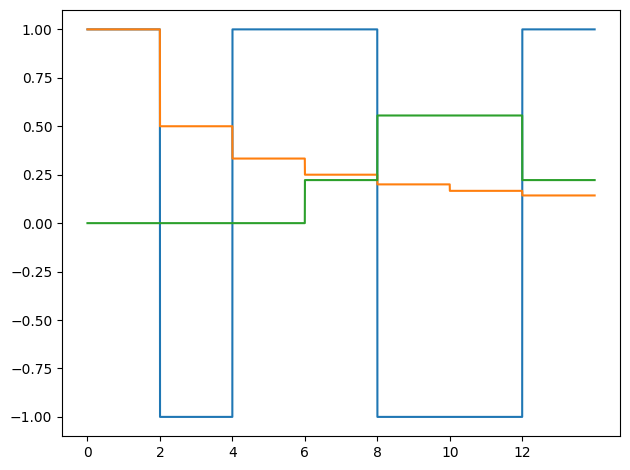

In [2]:
env = Environment(sid=1, trial=2, time_sample=2)
print(env.empirical)
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(0, env.T+env.dt, env.dt), env.colors)
ax.plot(np.arange(0, env.T+env.dt, env.dt), env.decays)
ax.plot(np.arange(0, env.T+env.dt, env.dt), env.degrees)
# ax.plot(np.arange(0, env.T+env.dt, env.dt), env.n_samples)
ax.set(xticks = np.arange(0, env.T+env.dt, env.time_sample))
plt.tight_layout()
plt.show()

In [3]:
env = Environment(sid=1, trial=3)
net, sim = simulate_WM(env, z=2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

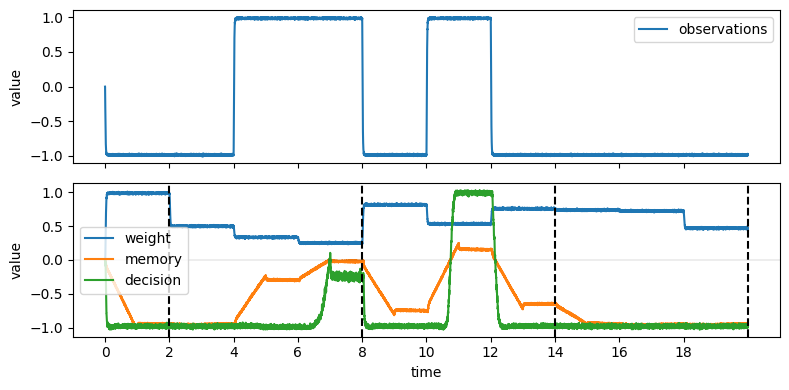

In [4]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
mem = sim.data[net.probe_memory].flatten()
decision = sim.data[net.probe_decision][:,0].flatten()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
sns.lineplot(x=times, y=mem, ax=axes[1], label='memory')
sns.lineplot(x=times, y=decision, ax=axes[1], label='decision')
axes[1].axhline(0, color='k', lw=0.1)
axes[1].axvline(env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+env.n_neighbors*env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+2*env.n_neighbors*env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+3*env.n_neighbors*env.time_sample, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+env.dt, env.time_sample))
plt.tight_layout()

### Simulate all trials for one SID, record results

In [5]:
empirical = pd.read_pickle(f"data/behavior.pkl")
sids = empirical['sid'].unique()
run_WM(sids[0], z=1)

sid 1, trial 1
sid 1, trial 2
sid 1, trial 3
sid 1, trial 4
sid 1, trial 5


KeyboardInterrupt: 